In [ ]:
# Need to find "transforms"

In [128]:
import numpy as np
import pandas as pd
import csv
import torch

from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image


In [146]:
%load_ext autoreload
%autoreload 2
from main.utils.loaders import FaceDataSet
from main.viz.image_grids import imshow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


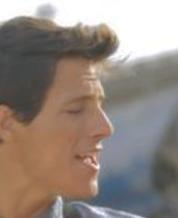

In [64]:
img_ = Image.open('data/raw/imgs/img_align_celeba/000003.jpg')
img_

In [10]:
with open('data/raw/annotations/list_landmarks_align_celeba.txt') as csv_file:
            data = list(csv.reader(csv_file, delimiter=' ', skipinitialspace=True))

data_labs = pd.DataFrame(data[2:])

data_labs.columns = ['img_id'] + data[1]
data_labs = data_labs.astype(dict(zip(data_labs.columns[1:], [float]*len(data_labs.columns[1:]))))

In [110]:
def mean_dist(name_string, all_data):
    x_coord = name_string+'_x'
    y_coord = name_string+'_y'

    mean_data = pd.DataFrame(data_labs.iloc[:,1:].mean(axis=0))
    x_mean = mean_data.loc[x_coord, :]
    y_mean = mean_data.loc[y_coord, :]

    a_vec = np.array([x_mean, y_mean]).reshape(-1,2)
    b_vec = np.vstack([all_data.loc[:,x_coord], all_data.loc[:,y_coord]]).T

    dist = np.linalg.norm(a_vec-b_vec, axis=1)

    return dist

In [60]:
for col_ in ['lefteye', 'righteye', 'nose', 'leftmouth', 'rightmouth']:
    data_labs[col_+'_mean'] = mean_dist(col_, data_labs)

data_labs['total_sum'] = data_labs.loc[:, ['lefteye_mean', 'righteye_mean', 'nose_mean', 'leftmouth_mean', 'rightmouth_mean']].sum(axis=1)

In [75]:
lowest_ranks = data_labs.sort_values('total_sum').head(5000)
want_photos = lowest_ranks.loc[:, ['img_id']]

# Recast

In [147]:
with open('data/raw/annotations/list_attr_celeba.txt') as csv_file:
            data = list(csv.reader(csv_file, delimiter=' ', skipinitialspace=True))

data_labs = pd.DataFrame(data[2:])
data_labs.columns = ['img_id'] + data[1][:-1]
data_labs.iloc[:,25] = np.where(data_labs.iloc[:,25] == '1', 1, 0)
data_labs = data_labs.merge(want_photos, how='inner')

In [148]:
#  Load model and prepare
weights_resnet = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights_resnet)
preprocessor_ = weights_resnet.transforms()

In [149]:
train_ds = FaceDataSet(data_labs, transform=preprocessor_)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 224, 224]) torch.Size([128])


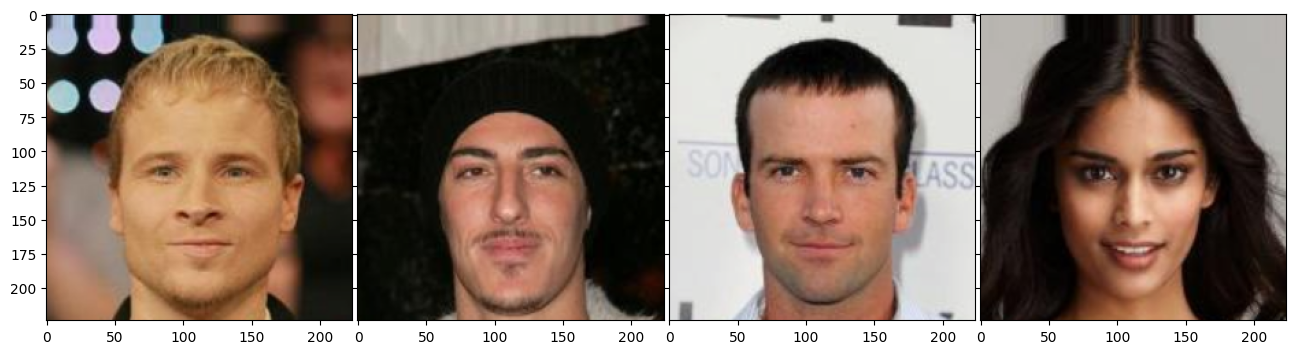

In [150]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(4):
    ax = grid[i]
    imshow(ax, img[i])

Seems to work quite well

In [112]:
data_labs.to_csv('data/prepared/faces/direct_faces.csv', index=False)

# Interpolation

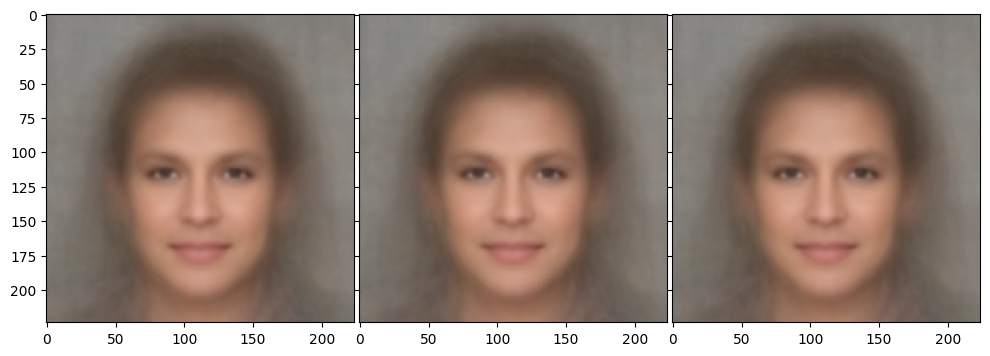

In [151]:
img, label = next(iter(train_dl))
mean_img = torch.mean(img, 0)
fig = plt.figure(1, figsize=(16, 4))

grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.05)    
for i in range(3):
    ax = grid[i]
    imshow(ax, mean_img)

In [157]:
img_all = torch.empty_like(img)
labs_all = torch.empty_like(label)
for img, label in train_dl:
    img_all = torch.cat([img_all, img], 0)
    labs_all = torch.cat([labs_all, label])

img_all = img_all[128:,:,:,:]
labs_all = labs_all[128:]

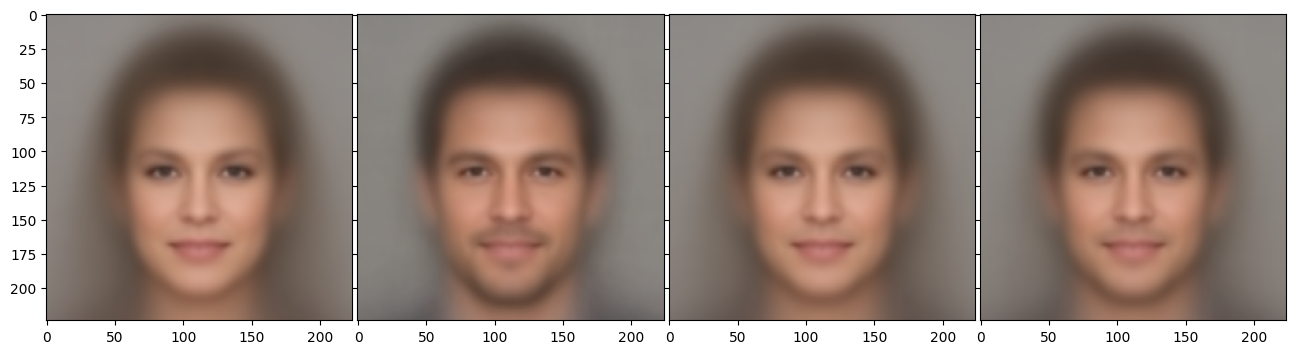

In [174]:
mean_img = torch.mean(img_all, 0)
mean_nobeard = torch.mean(img_all[labs_all == 1,:,:,:], 0)
mean_beard = torch.mean(img_all[labs_all == 0,:,:,:], 0)
mean_two = torch.mean(torch.stack([mean_nobeard, mean_beard]), 0) # Equal weights

fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)


imshow(grid[0], mean_nobeard)
imshow(grid[1], mean_beard)
imshow(grid[2], mean_img)
imshow(grid[3], mean_two)